### This document is for linking REDCap, ACCESS, and TSQIC datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# TSQIC tabs merging

In [2]:
# Load the Excel file
file_path = "Complications_TSQIC_TC_13_02_2025.xlsx" 
df_tsqic = pd.read_excel(file_path, sheet_name=None)

# Display sheet names
print(df_tsqic.keys())

# Access specific sheets/tabs
df_tsqic_1 = df_tsqic["TSQIC-Complications"]  
df_tsqic_2 = df_tsqic["TSQIC-admission-discharge dates"] 
print(df_tsqic_1)
print(df_tsqic_2)

dict_keys(['TSQIC-Complications', 'TSQIC-admission-discharge dates'])
        id date (operation) ComplicationDate     System       Complication  \
0      817       2016-09-07       2016-09-08    Cardiac       Hypotension    
1      190       2016-09-07       2016-09-08    Cardiac  Atrial Arrhythmia   
2      817       2016-09-07       2016-09-09    Cardiac  Atrial Arrhythmia   
3      190       2016-09-07       2016-09-10  Pulmonary         Hemoptysis   
4      817       2016-09-07       2016-09-11    Cardiac       Hypertension   
...    ...              ...              ...        ...                ...   
1557  1705       2024-09-04       2024-09-10  Pulmonary        Atelactasis   
1558  1705       2024-09-04       2024-09-10    Pleural           Effusion   
1559  1705       2024-09-04       2024-09-11      Anast   Mucosal necrosis   
1560  1687       2024-09-08       2024-09-16    Pleural           Effusion   
1561  1687       2024-09-08       2024-09-16    Pleural  Hydropneumothor

In [3]:
# Standardize column names for merging
df_tsqic_1 = df_tsqic_1.rename(columns={"date (operation)": "operation_date", "Readmission":"readmission_30d"})
df_tsqic_2 = df_tsqic_2.rename(columns={"Date (operation)": "operation_date"})


# Convert operation_date to datetime for proper matching
df_tsqic_1["operation_date"] = pd.to_datetime(df_tsqic_1["operation_date"])
df_tsqic_2["operation_date"] = pd.to_datetime(df_tsqic_2["operation_date"])

# Merge with cartesian product for matched rows
merged_matched = df_tsqic_1.merge(df_tsqic_2, on=["id", "operation_date"], how="outer", indicator=True)

# Display the result -> _merge column=> left_only: appear TSQIC-Complications tab only + right_only: appear TSQIC-admission-discharge dates tab only 
print(merged_matched)

        id operation_date ComplicationDate   System             Complication  \
0       37     2023-05-03              NaT      NaN                      NaN   
1       44     2019-05-21              NaT      NaN                      NaN   
2       55     2019-10-22              NaT      NaN                      NaN   
3       76     2021-05-18       2021-05-21  Gastric                    Ileus   
4       78     2019-09-03              NaT      NaN                      NaN   
...    ...            ...              ...      ...                      ...   
2341  1748     2024-07-23       2024-08-12  Pleural             Pneumothorax   
2342  1748     2024-07-23       2024-08-13    Anast                     Leak   
2343  1748     2024-08-13       2024-08-16  Gastric  Non Infectious Diarrhea   
2344  1748     2024-08-19       2024-08-21  Gastric                 Vomiting   
2345  1748     2024-08-26              NaT      NaN                      NaN   

      Grade          GradeLetter  readm

### Merging examination

In [4]:
# Confirm if merging went well

# IDs in df_tsqic_1 but not in df_tsqic_2 -> no missing value so it makes sense that we dont have "left_only"
missing_in_2 = df_tsqic_1[~df_tsqic_1["id"].isin(df_tsqic_2["id"])]
print("IDs missing in df_tsqic_2:", missing_in_2)

# IDs in df_tsqic_2 but not in df_tsqic_1
missing_in_1 = df_tsqic_2[~df_tsqic_2["id"].isin(df_tsqic_1["id"])]
print("\n\nIDs missing in df_tsqic_1:", missing_in_1)


IDs missing in df_tsqic_2: Empty DataFrame
Columns: [id, operation_date, ComplicationDate, System, Complication, Grade, GradeLetter, readmission_30d, Prolonged, Comments]
Index: []


IDs missing in df_tsqic_1:         id operation_date DischargeDate
0     1692     2024-09-16           NaT
15    1673     2024-07-24    2024-07-30
26    1558     2024-07-18    2024-07-23
27    1653     2024-07-10    2024-07-16
29    1604     2023-08-16    2023-08-22
...    ...            ...           ...
1222   649     2016-10-13    2016-10-19
1223   678     2016-10-03    2016-10-04
1224   647     2016-10-18    2016-10-24
1251   652     2016-09-12    2016-09-14
1259   634     2017-03-14    2017-03-28

[278 rows x 3 columns]


In [5]:
# Go deeper into right_only
right_only_count = (merged_matched["_merge"] == "right_only").sum()
print(f"Number of right-only rows: {right_only_count}")

Number of right-only rows: 677


In [6]:
# Convert date columns to strings if they are datetime (to avoid potential type mismatches)
df_tsqic_1["date"] = df_tsqic_1["operation_date"].astype(str)
df_tsqic_2["date"] = df_tsqic_2["operation_date"].astype(str)

# Create a set of (ID, Date) pairs from df_tsqic_1
id_date_set_1 = set(zip(df_tsqic_1["id"], df_tsqic_1["date"]))

# Filter rows in df_tsqic_2 where (ID, Date) is not in df_tsqic_1
missing_pairs_in_1 = df_tsqic_2[~df_tsqic_2.apply(lambda row: (row["id"], row["date"]) in id_date_set_1, axis=1)]

print("ID-Date pairs in df_tsqic_2 but not in df_tsqic_1:\n", missing_pairs_in_1[["id", "date"]])
#677 rows matched! so it went well. 

ID-Date pairs in df_tsqic_2 but not in df_tsqic_1:
         id        date
0     1692  2024-09-16
2     1705  2024-09-11
7     1707  2024-09-12
8     1707  2024-08-31
15    1673  2024-07-24
...    ...         ...
1251   652  2016-09-12
1252   190  2016-09-19
1256   668  2016-12-23
1258   668  2016-11-17
1259   634  2017-03-14

[677 rows x 2 columns]


In [7]:
#estimated_los: difference between these two dates most often corresponds with length of stay, LOS
merged_matched["estimated_los"] = (merged_matched["DischargeDate"] - merged_matched["operation_date"]).dt.days
print(merged_matched["estimated_los"].describe())  # Summary statistics
print("\n\n")
print(merged_matched[merged_matched["estimated_los"] < 0])  # Check for negative LOS values
print("\n\n")
print(merged_matched[merged_matched["estimated_los"].isna()])  # Check for missing values


count    2249.000000
mean       26.930191
std        38.159772
min      -358.000000
25%         7.000000
50%        14.000000
75%        34.000000
max       422.000000
Name: estimated_los, dtype: float64



        id operation_date ComplicationDate   System       Complication  Grade  \
1692  1318     2021-12-03              NaT      NaN                NaN    NaN   
1956  1549     2023-03-01       2023-03-03  Cardiac  Atrial Arrhythmia    2.0   
1958  1549     2023-03-01       2023-03-03  Cardiac  Atrial Arrhythmia    2.0   

              GradeLetter  readmission_30d  Prolonged Comments DischargeDate  \
1692                  NaN              NaN        NaN      NaN    2021-01-07   
1956  II - New Medication              0.0        0.0      NaN    2022-03-08   
1958  II - New Medication              0.0        0.0      NaN    2022-03-08   

          _merge  estimated_los  
1692  right_only         -330.0  
1956        both         -358.0  
1958        both         -358.0  



        

In [8]:
merged_matched

,id,operation_date,ComplicationDate,System,Complication,Grade,GradeLetter,readmission_30d,Prolonged,Comments,DischargeDate,_merge,estimated_los
0,37,2023-05-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-06,right_only,3.0
1,44,2019-05-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-23,right_only,2.0
2,55,2019-10-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-28,right_only,6.0
3,76,2021-05-18,2021-05-21,Gastric,Ileus,2.0,II - New Medication,0.0,0.0,NaN,2021-05-25,both,7.0
4,78,2019-09-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-10,right_only,373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,1748,2024-07-23,2024-08-12,Pleural,Pneumothorax,2.0,II - New Medication,1.0,0.0,NaN,2024-07-30,both,7.0
2342,1748,2024-07-23,2024-08-13,Anast,Leak,3.0,IIIa - Intervention,0.0,0.0,Endo-vac and stent placement,2024-07-30,both,7.0
2343,1748,2024-08-13,2024-08-16,Gastric,Non Infectious Diarrhea,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,17.0
2344,1748,2024-08-19,2024-08-21,Gastric,Vomiting,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,11.0


In [9]:
merged_matched["_merge"] = merged_matched["_merge"].replace("right_only", "secondtab_only")
merged_matched

/tmp/ipykernel_245195/1792273686.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_matched["_merge"] = merged_matched["_merge"].replace("right_only", "secondtab_only")


,id,operation_date,ComplicationDate,System,Complication,Grade,GradeLetter,readmission_30d,Prolonged,Comments,DischargeDate,_merge,estimated_los
0,37,2023-05-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-06,secondtab_only,3.0
1,44,2019-05-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-23,secondtab_only,2.0
2,55,2019-10-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-28,secondtab_only,6.0
3,76,2021-05-18,2021-05-21,Gastric,Ileus,2.0,II - New Medication,0.0,0.0,NaN,2021-05-25,both,7.0
4,78,2019-09-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-10,secondtab_only,373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,1748,2024-07-23,2024-08-12,Pleural,Pneumothorax,2.0,II - New Medication,1.0,0.0,NaN,2024-07-30,both,7.0
2342,1748,2024-07-23,2024-08-13,Anast,Leak,3.0,IIIa - Intervention,0.0,0.0,Endo-vac and stent placement,2024-07-30,both,7.0
2343,1748,2024-08-13,2024-08-16,Gastric,Non Infectious Diarrhea,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,17.0
2344,1748,2024-08-19,2024-08-21,Gastric,Vomiting,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,11.0


In [10]:
merged_matched = merged_matched.rename(columns={"_merge": "_merge_tsqic"})
merged_matched

,id,operation_date,ComplicationDate,System,Complication,Grade,GradeLetter,readmission_30d,Prolonged,Comments,DischargeDate,_merge_tsqic,estimated_los
0,37,2023-05-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-06,secondtab_only,3.0
1,44,2019-05-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-23,secondtab_only,2.0
2,55,2019-10-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-28,secondtab_only,6.0
3,76,2021-05-18,2021-05-21,Gastric,Ileus,2.0,II - New Medication,0.0,0.0,NaN,2021-05-25,both,7.0
4,78,2019-09-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-10,secondtab_only,373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,1748,2024-07-23,2024-08-12,Pleural,Pneumothorax,2.0,II - New Medication,1.0,0.0,NaN,2024-07-30,both,7.0
2342,1748,2024-07-23,2024-08-13,Anast,Leak,3.0,IIIa - Intervention,0.0,0.0,Endo-vac and stent placement,2024-07-30,both,7.0
2343,1748,2024-08-13,2024-08-16,Gastric,Non Infectious Diarrhea,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,17.0
2344,1748,2024-08-19,2024-08-21,Gastric,Vomiting,2.0,II - New Medication,0.0,0.0,NaN,2024-08-30,both,11.0


In [64]:
# Save to a new Excel file
merged_matched.to_excel("Merged_TSQIC.xlsx", index=False)

# TSQIC REDCap_FactE merging

In [12]:
# Read the CSV file - emotional distress 
file_path = "EsophagealBank-EmotionalDistress_DATA_2025-02-13_1201.csv"
df_redcap = pd.read_csv(file_path)
df_redcap

/tmp/ipykernel_245195/1873760663.py:3: DtypeWarning: Columns (93,99,108,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df_redcap = pd.read_csv(file_path)


,id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,qol_date,gp1,gp2,gp3,gp4,gp5,...,comp_pulm,other_pulm,grade_pulm,comp_renal,other_renal,grade_renal,comp_wound,other_wound,grade_wound,postop_comp
0,1,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5_years_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,surgery_arm_1,surgery_esd_emr,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,surgery_arm_1,postoperative_course,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,surgery_arm_1,postoperative_complications,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615,1756,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9616,1756,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,3.0,0.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9617,1757,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9618,1757,baseline_arm_1,functional_assessment_of_cancer_therapy_fact_e...,1.0,1/27/2025,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Column name change before merged 
df_redcap = df_redcap.rename(columns={"complication_date": "ComplicationDate", "system": "System", "discharge_date": "DischargeDate", "admission_date": "admission_date_redcap"})

In [14]:
merged_final = merged_matched.merge(df_redcap, on="id", how="outer", suffixes=("_tsqic", "_redcap"), validate="m:m", indicator="_merge_tsqic_redcap")
merged_final

,id,operation_date,ComplicationDate_tsqic,System_tsqic,Complication,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,other_pulm,grade_pulm,comp_renal,other_renal,grade_renal,comp_wound,other_wound,grade_wound,postop_comp,_merge_tsqic_redcap
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,right_only
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
19995,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
19996,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
19997,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only


### Merging examination

In [15]:
merged_final["_merge_tsqic_redcap"] = merged_final["_merge_tsqic_redcap"].replace("right_only", "redcap_only")
merged_final["_merge_tsqic_redcap"] = merged_final["_merge_tsqic_redcap"].replace("left_only", "tsqic_only")
merged_final

/tmp/ipykernel_245195/812828160.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_final["_merge_tsqic_redcap"] = merged_final["_merge_tsqic_redcap"].replace("right_only", "redcap_only")
/tmp/ipykernel_245195/812828160.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_final["_merge_tsqic_redcap"] = merged_final["_merge_tsqic_redcap"].replace("left_only", "tsqic_only")


,id,operation_date,ComplicationDate_tsqic,System_tsqic,Complication,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,other_pulm,grade_pulm,comp_renal,other_renal,grade_renal,comp_wound,other_wound,grade_wound,postop_comp,_merge_tsqic_redcap
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,redcap_only
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
19995,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
19996,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only
19997,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redcap_only


In [16]:
# Confirm if merging went well

# IDs in TSQIC but not in df_redcap
missing_in_redcap = merged_matched[~merged_matched["id"].isin(df_redcap["id"])]
print("IDs missing in df_redcap:", missing_in_redcap)

# IDs in df_redcap but not in TSQIC
missing_in_matched = df_redcap[~df_redcap["id"].isin(merged_matched["id"])]
print("\n\nIDs missing in merged_matched:", missing_in_matched)



IDs missing in df_redcap: Empty DataFrame
Columns: [id, operation_date, ComplicationDate, System, Complication, Grade, GradeLetter, readmission_30d, Prolonged, Comments, DischargeDate, _merge_tsqic, estimated_los]
Index: []


IDs missing in merged_matched:         id     redcap_event_name  \
0        1        baseline_arm_1   
1        1  5_years_postop_arm_1   
2        1         surgery_arm_1   
3        1         surgery_arm_1   
4        1         surgery_arm_1   
...    ...                   ...   
9615  1756        baseline_arm_1   
9616  1756        baseline_arm_1   
9617  1757        baseline_arm_1   
9618  1757        baseline_arm_1   
9619  1758        baseline_arm_1   

                               redcap_repeat_instrument  \
0                                                   NaN   
1                                                   NaN   
2                                       surgery_esd_emr   
3                                  postoperative_course   
4              

In [17]:

right_only_count = (merged_final["_merge_tsqic_redcap"] == "tsqic_only").sum()
print(f"Number of tsqic-only rows: {right_only_count}")

right_only_count = (merged_final["_merge_tsqic_redcap"] == "redcap_only").sum()
print(f"Number of redcap-only rows: {right_only_count}")

Number of tsqic-only rows: 0
Number of redcap-only rows: 5679


In [18]:
# Save to a new Excel file
merged_final.to_excel("Merged_TSQIC_REDCap.xlsx", index=False)

# ACCESS tabs merging

In [19]:
# Load the Excel file
file_path = "Complications_ACCESS_TC_21_02_2025.xlsx" #"Complications_ACCESS_TC_13_02_2025.xlsx" 
df_access = pd.read_excel(file_path, sheet_name=None)

# Display sheet names
print(df_access.keys())

# Access specific sheets/tabs
df_access_1 = df_access["Complications"]  
df_access_2 = df_access["operation"]   #df_access_2 = df_access["Admission-discharge date"] 
df_access_3 = df_access["admit-discharge"]  


print(df_access_1)
print(df_access_2)
print(df_access_3)

dict_keys(['Complications', 'operation', 'admit-discharge'])
       id  Case number Complication_Date                         Complication  \
0     253     98832874        2010-11-17         Confusion / post op delerium   
1     247     98854559        2010-06-05                  Febrile neutropenia   
2     247     98854559        2010-06-07                                  DVT   
3     251     98834084        2010-11-13                  Vocalcord paralysis   
4     251     98834084        2010-11-15                           Chyle leak   
...   ...          ...               ...                                  ...   
1501  248     98839515        2010-10-05  Atrial fibrillation / flutter / SVT   
1502  248     98839515        2010-10-06                     Anastamosis leak   
1503  239     98838392        2010-10-15                    Stroke (> 7 days)   
1504  239     98838392        2010-10-16         Confusion / post op delerium   
1505  239     98838392        2010-10-21        

In [22]:
# Standardize column names for merging
#df_access_1 = df_access_1.rename(columns={"Complication_Date": "ComplicationDate_access", "Thoracic Surgeries_Date": "operation_date"})
#df_access_2 = df_access_2.rename(columns={"Actual D/C": "DischargeDate_access", "Hospital Admit Date" :"admission_date_access"})
df_access_1 = df_access_1.rename(columns={"Complication_Date": "ComplicationDate_access", "Case number": "Case Number"})
df_access_2 = df_access_2.rename(columns={"Thoracic Surgeries_Date": "operation_date"})
df_access_3 = df_access_3.rename(columns={"Actual D/C": "DischargeDate_access", "Hospital Admit Date" :"admission_date_access"})

# Convert operation_date to datetime for proper matching
# df_access_1["operation_date"] = pd.to_datetime(df_access_1["operation_date"])
# df_access_1["ComplicationDate_access"] = pd.to_datetime(df_access_1["ComplicationDate_access"])
df_access_1["ComplicationDate_access"] = pd.to_datetime(df_access_1["ComplicationDate_access"])
df_access_2["operation_date"] = pd.to_datetime(df_access_2["operation_date"])


# Merge with cartesian product for matched rows
merged_matched_access12 = df_access_1.merge(df_access_2, on=["Case Number", "id"], how="outer", indicator=False)
merged_matched_access12

,id,Case Number,ComplicationDate_access,Complication,Clavien score,operation_date
0,293,80699665,NaT,NaN,NaN,2011-05-31
1,263,80702859,NaT,NaN,NaN,2010-11-25
2,169,80704783,NaT,NaN,NaN,2010-08-12
3,139,80704906,NaT,NaN,NaN,2010-08-12
4,183,80704907,NaT,NaN,NaN,2010-08-12
...,...,...,...,...,...,...
3151,639,2016006328,NaT,NaN,NaN,2016-09-02
3152,639,2016006328,NaT,NaN,NaN,2016-07-30
3153,639,2016006328,NaT,NaN,NaN,2016-08-13
3154,190,2016006522,NaT,NaN,NaN,2016-09-07


In [24]:
# Display the result -> _merge column=> left_only: appear Complications tab only + right_only: appear admission-discharge dates tab only 
merged_matched_access = merged_matched_access12.merge(df_access_3, on=["Case Number", "id"], how="outer", indicator=True)
print(merged_matched_access)

       id  Case Number ComplicationDate_access Complication Clavien score  \
0     293     80699665                     NaT          NaN           NaN   
1     263     80702859                     NaT          NaN           NaN   
2     169     80704783                     NaT          NaN           NaN   
3     139     80704906                     NaT          NaN           NaN   
4     183     80704907                     NaT          NaN           NaN   
...   ...          ...                     ...          ...           ...   
3348  663   2016006745                     NaT          NaN           NaN   
3349  973   2016006823                     NaT          NaN           NaN   
3350  661   2016006893                     NaT          NaN           NaN   
3351  661   2016007187                     NaT          NaN           NaN   
3352  667   2016007341                     NaT          NaN           NaN   

     operation_date admission_date_access DischargeDate_access      _merge 

### Merging examination

In [25]:
# Confirm if merging went well

# IDs in df_access_12 but not in df_access_3 -> no missing value so it makes sense that we dont have "left_only"
missing_in_3 = merged_matched_access12[~merged_matched_access12["Case Number"].isin(df_access_3["Case Number"])]
print("Case numbers missing in df_access_3:", missing_in_3)

# IDs in df_access_3 but not in df_access_12
missing_in_12 = df_access_3[~df_access_3["Case Number"].isin(merged_matched_access12["Case Number"])]
print("\n\nCase numbers missing in df_access_1:", missing_in_12)


Case numbers missing in df_access_3: Empty DataFrame
Columns: [id, Case Number, ComplicationDate_access, Complication, Clavien score, operation_date]
Index: []


Case numbers missing in df_access_1:       id  Case Number admission_date_access DischargeDate_access
44   392     98702001            2013-08-06           2013-08-12
45   375     98702641            2013-07-10           2013-07-19
47   386     98703744            2013-07-02           2013-07-04
48   336     98705667            2013-06-17           2013-06-28
52   294     98709113            2013-05-23           2013-05-24
..   ...          ...                   ...                  ...
818  817   2016006528            2016-09-07           2016-09-13
819  663   2016006745            2016-09-11           2016-09-26
821  661   2016006893            2016-09-14           2016-10-16
822  661   2016007187            2016-09-21           2016-10-12
823  667   2016007341            2016-09-24           2016-09-28

[197 rows x 4 column

In [26]:
# Go deeper into right_only
right_only_count_access = (merged_matched_access["_merge"] == "right_only").sum()
print(f"Number of right-only rows: {right_only_count_access}")

Number of right-only rows: 197


In [27]:
#estimated_los: difference between these two dates most often corresponds with length of stay, LOS
merged_matched_access["estimated_los"] = (merged_matched_access["DischargeDate_access"] - merged_matched_access["operation_date"]).dt.days
print(merged_matched_access["estimated_los"].describe())  # Summary statistics
print("\n\n")
print(merged_matched_access[merged_matched_access["estimated_los"] < 0])  # Check for negative LOS values
print("\n\n")
print(merged_matched_access[merged_matched_access["estimated_los"].isna()])  # Check for missing values


count    3017.000000
mean       46.862115
std        55.481210
min       -13.000000
25%        13.000000
50%        31.000000
75%        78.000000
max      2194.000000
Name: estimated_los, dtype: float64



       id  Case Number ComplicationDate_access Complication Clavien score  \
314   314     98782217                     NaT          NaN           NaN   
405   285     98809355                     NaT          NaN           NaN   
1619  438   2014005660                     NaT          NaN           NaN   

     operation_date admission_date_access DischargeDate_access _merge  \
314      2011-12-10            2011-12-20           2011-11-27   both   
405      2011-05-30            2011-05-20           2011-05-27   both   
1619     2014-08-07            2014-08-05           2014-08-06   both   

      estimated_los  
314           -13.0  
405            -3.0  
1619           -1.0  



       id  Case Number ComplicationDate_access Complication Clavien score  \
45    392     98702001 

In [28]:
merged_matched_access

,id,Case Number,ComplicationDate_access,Complication,Clavien score,operation_date,admission_date_access,DischargeDate_access,_merge,estimated_los
0,293,80699665,NaT,NaN,NaN,2011-05-31,2011-05-31,2011-05-31,both,0.0
1,263,80702859,NaT,NaN,NaN,2010-11-25,2010-11-25,2010-11-25,both,0.0
2,169,80704783,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
3,139,80704906,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
4,183,80704907,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
...,...,...,...,...,...,...,...,...,...,...
3348,663,2016006745,NaT,NaN,NaN,NaT,2016-09-11,2016-09-26,right_only,NaN
3349,973,2016006823,NaT,NaN,NaN,2016-09-13,2016-09-13,2016-10-02,both,19.0
3350,661,2016006893,NaT,NaN,NaN,NaT,2016-09-14,2016-10-16,right_only,NaN
3351,661,2016007187,NaT,NaN,NaN,NaT,2016-09-21,2016-10-12,right_only,NaN


In [29]:
merged_matched_access["_merge"] = merged_matched_access["_merge"].replace("right_only", "thirdtab_only")
merged_matched_access

/tmp/ipykernel_245195/465534187.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_matched_access["_merge"] = merged_matched_access["_merge"].replace("right_only", "thirdtab_only")


,id,Case Number,ComplicationDate_access,Complication,Clavien score,operation_date,admission_date_access,DischargeDate_access,_merge,estimated_los
0,293,80699665,NaT,NaN,NaN,2011-05-31,2011-05-31,2011-05-31,both,0.0
1,263,80702859,NaT,NaN,NaN,2010-11-25,2010-11-25,2010-11-25,both,0.0
2,169,80704783,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
3,139,80704906,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
4,183,80704907,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
...,...,...,...,...,...,...,...,...,...,...
3348,663,2016006745,NaT,NaN,NaN,NaT,2016-09-11,2016-09-26,thirdtab_only,NaN
3349,973,2016006823,NaT,NaN,NaN,2016-09-13,2016-09-13,2016-10-02,both,19.0
3350,661,2016006893,NaT,NaN,NaN,NaT,2016-09-14,2016-10-16,thirdtab_only,NaN
3351,661,2016007187,NaT,NaN,NaN,NaT,2016-09-21,2016-10-12,thirdtab_only,NaN


In [30]:
merged_matched_access = merged_matched_access.rename(columns={"_merge": "_merge_access"})
merged_matched_access

,id,Case Number,ComplicationDate_access,Complication,Clavien score,operation_date,admission_date_access,DischargeDate_access,_merge_access,estimated_los
0,293,80699665,NaT,NaN,NaN,2011-05-31,2011-05-31,2011-05-31,both,0.0
1,263,80702859,NaT,NaN,NaN,2010-11-25,2010-11-25,2010-11-25,both,0.0
2,169,80704783,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
3,139,80704906,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
4,183,80704907,NaT,NaN,NaN,2010-08-12,2010-08-12,2010-08-12,both,0.0
...,...,...,...,...,...,...,...,...,...,...
3348,663,2016006745,NaT,NaN,NaN,NaT,2016-09-11,2016-09-26,thirdtab_only,NaN
3349,973,2016006823,NaT,NaN,NaN,2016-09-13,2016-09-13,2016-10-02,both,19.0
3350,661,2016006893,NaT,NaN,NaN,NaT,2016-09-14,2016-10-16,thirdtab_only,NaN
3351,661,2016007187,NaT,NaN,NaN,NaT,2016-09-21,2016-10-12,thirdtab_only,NaN


In [31]:
# Save to a new Excel file
merged_matched_access.to_excel("Merged_ACCESS.xlsx", index=False)

# TSQIC REDCap_FactE ACCESS merging

In [58]:
merged_final_tsqic_redcap_access = merged_final.merge(merged_matched_access, on="id", how="outer", suffixes=("_tsqic", "_access"), validate="m:m", indicator="_merge_tsqic_redcap_access")
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,both
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,both
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,both
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,both
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,left_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,left_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,left_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,left_only


### Merging examination

In [59]:
merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] = merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"].replace("both", "all")
merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] = merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"].replace("right_only", "access_only")
merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] = merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"].replace("left_only", "tsqic_redcap_only")
merged_final_tsqic_redcap_access

/tmp/ipykernel_245195/732235441.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] = merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"].replace("both", "all")
/tmp/ipykernel_245195/732235441.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] = merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"].replace("right_only", "access_only")
/tmp/ipykernel_245195/732235441.py:3: FutureWarning: The behavior of Series.replace (a

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [60]:
# Confirm if merging went well

# IDs in access but not in tsqic or redcap
missing_in_redcap = merged_matched_access[~merged_matched_access["id"].isin(merged_final["id"])]
print("IDs missing in tsqic or redcap:", missing_in_redcap)

# IDs in TSQIC or redcap but not in access
missing_in_matched = merged_final[~merged_final["id"].isin(merged_matched_access["id"])]
print("\n\nIDs missing in access:", missing_in_matched)

IDs missing in tsqic or redcap:         id  Case Number ComplicationDate_access Complication Clavien score  \
1270  1759     99004893                     NaT          NaN           NaN   

     operation_date admission_date_access DischargeDate_access _merge_access  \
1270     2007-04-02            2007-04-02           2007-04-05          both   

      estimated_los  
1270            3.0  


IDs missing in access:          id operation_date ComplicationDate_tsqic System_tsqic Complication  \
35        6            NaT                    NaT          NaN          NaN   
36        6            NaT                    NaT          NaN          NaN   
37        6            NaT                    NaT          NaN          NaN   
38        6            NaT                    NaT          NaN          NaN   
39        6            NaT                    NaT          NaN          NaN   
...     ...            ...                    ...          ...          ...   
19994  1756            NaT  

In [62]:
right_only_count = (merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] == "access_only").sum()
print(f"Number of access-only rows: {right_only_count}")

left_only_count = (merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] == "tsqic_redcap_only").sum()
print(f"Number of tsqic-redcap-only rows: {left_only_count}")

all_count = (merged_final_tsqic_redcap_access["_merge_tsqic_redcap_access"] == "all").sum()
print(f"Number of all available: {all_count}")

Number of access-only rows: 1
Number of tsqic-redcap-only rows: 15980
Number of all available: 33147


In [63]:
# Save to a new Excel file
merged_final_tsqic_redcap_access.to_excel("Merged_TSQIC_REDCap_ACCESS.xlsx", index=False)

# Data cleaning (based on knowledge: reasonable condition)

In [65]:
file_path = "Merged_TSQIC_REDCap_ACCESS.xlsx" 
merged_final_tsqic_redcap_access = pd.read_excel(file_path)

In [66]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


### LOS negation removal - TSQIC

In [67]:
#LOS from TSQIC
print(merged_final_tsqic_redcap_access["estimated_los_tsqic"].describe())  # Summary statistics
print("\n\n")
print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access["estimated_los_tsqic"] < 0])  # Check for negative LOS values
print("\n\n")

count    14932.000000
mean        26.884275
std         36.508833
min       -358.000000
25%          7.000000
50%         15.000000
75%         35.000000
max        422.000000
Name: estimated_los_tsqic, dtype: float64



         id operation_date_tsqic ComplicationDate_tsqic System_tsqic  \
44929  1318           2021-12-03                    NaT          NaN   
44930  1318           2021-12-03                    NaT          NaN   
44931  1318           2021-12-03                    NaT          NaN   
44932  1318           2021-12-03                    NaT          NaN   
44933  1318           2021-12-03                    NaT          NaN   
44934  1318           2021-12-03                    NaT          NaN   
44935  1318           2021-12-03                    NaT          NaN   
46688  1549           2023-03-01             2023-03-03      Cardiac   
46689  1549           2023-03-01             2023-03-03      Cardiac   
46690  1549           2023-03-01             2023-03-03    

In [68]:
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["estimated_los_tsqic"] >= 0) |
    (merged_final_tsqic_redcap_access["estimated_los_tsqic"].isna())
]

#LOS from TSQIC
print(merged_final_tsqic_redcap_access["estimated_los_tsqic"].describe())  # Summary statistics
print("\n\n")
print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access["estimated_los_tsqic"] < 0])  # Check for negative LOS values
print("\n\n")

count    14917.000000
mean        27.258162
std         34.566926
min          0.000000
25%          7.000000
50%         15.000000
75%         35.000000
max        422.000000
Name: estimated_los_tsqic, dtype: float64



Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence___

### LOS negation removal - REDCap

In [69]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [70]:
#LOS from REDCap
print(merged_final_tsqic_redcap_access["los"].describe())  # Summary statistics
print("\n\n")
print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access["los"] < 0])  # Check for negative LOS values
print("\n\n")

count    1665.000000
mean       57.237237
std        50.687410
min         2.000000
25%         8.000000
50%        28.000000
75%       116.000000
max       371.000000
Name: los, dtype: float64



Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence___bone, distant_recurrence

### LOS negation removal - ACCESS

In [71]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [72]:
#LOS from ACCESS
print(merged_final_tsqic_redcap_access["estimated_los_access"].describe())  # Summary statistics
print("\n\n")
print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access["estimated_los_access"] < 0])  # Check for negative LOS values
print("\n\n")

count    29745.000000
mean        50.281089
std         48.355972
min        -13.000000
25%         16.000000
50%         40.000000
75%         78.000000
max       2194.000000
Name: estimated_los_access, dtype: float64



        id operation_date_tsqic ComplicationDate_tsqic System_tsqic  \
12447  285                  NaT                    NaT          NaN   
12448  285                  NaT                    NaT          NaN   
12449  285                  NaT                    NaT          NaN   
12450  285                  NaT                    NaT          NaN   
12451  285                  NaT                    NaT          NaN   
12452  285                  NaT                    NaT          NaN   
12453  285                  NaT                    NaT          NaN   
12454  285                  NaT                    NaT          NaN   
13010  314                  NaT                    NaT          NaN   
13012  314                  NaT                    NaT          NaN 

In [73]:
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["estimated_los_access"] >= 0) |
    (merged_final_tsqic_redcap_access["estimated_los_access"].isna())
]

#LOS from TSQIC
print(merged_final_tsqic_redcap_access["estimated_los_access"].describe())  # Summary statistics
print("\n\n")
print(merged_final_tsqic_redcap_access[merged_final_tsqic_redcap_access["estimated_los_access"] < 0])  # Check for negative LOS values
print("\n\n")

count    29723.000000
mean        50.322007
std         48.350272
min          0.000000
25%         16.000000
50%         40.000000
75%         78.000000
max       2194.000000
Name: estimated_los_access, dtype: float64



Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence__

### check sequence: hospital admit date → surgery/operation date → complication date or discharge date

##### TSQIC (have operation, complication, discharge dates)

In [75]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [76]:
#TSQIC check: operation date -> complication date 

# Identify rows where operation_date is after ComplicationDate
violations = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["operation_date_tsqic"] > 
    merged_final_tsqic_redcap_access["ComplicationDate_tsqic"]
]
print(violations)

# Number of violating rows
print("Number of violating rows:", violations.shape[0])

# Remove rows with violations
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["operation_date_tsqic"] <= 
    merged_final_tsqic_redcap_access["ComplicationDate_tsqic"]) |
    (merged_final_tsqic_redcap_access["operation_date_tsqic"].isna()) |
    (merged_final_tsqic_redcap_access["ComplicationDate_tsqic"].isna())
]
print(merged_final_tsqic_redcap_access)


         id operation_date_tsqic ComplicationDate_tsqic System_tsqic  \
36703   748           2017-08-04             2017-07-30    Pulmonary   
36704   748           2017-08-04             2017-07-30    Pulmonary   
36705   748           2017-08-04             2017-07-30    Pulmonary   
37410   788           2018-03-28             2018-02-28      Cardiac   
37411   788           2018-03-28             2018-02-28      Cardiac   
37412   788           2018-03-28             2018-02-28      Cardiac   
37413   788           2018-03-28             2018-02-28      Cardiac   
37414   788           2018-03-28             2018-02-28      Cardiac   
37415   788           2018-03-28             2018-02-28      Cardiac   
37416   788           2018-03-28             2018-02-28      Cardiac   
37417   788           2018-03-28             2018-02-28      Cardiac   
38723   885           2019-01-18             2019-01-13        Anast   
38724   885           2019-01-18             2019-01-13        A

In [77]:
#TSQIC check: operation date -> discharge date 

# Identify rows where operation_date is after ComplicationDate
violations = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["operation_date_tsqic"] > 
    merged_final_tsqic_redcap_access["DischargeDate_tsqic"]
]
print(violations)

Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence___bone, distant_recurrence___brain, distant_recurrence___peritoneum, distant_recurrence___other, other_distant_recurrence, current_status, cause_death, last_fu_date, dod, recurrence_regional, recurrence_location___local, re

##### REDCap (have admit, complication, discharge dates)

In [78]:
print(merged_final_tsqic_redcap_access["admission_date_redcap"])
print(merged_final_tsqic_redcap_access["ComplicationDate_redcap"])

# Ensure both columns are in datetime format
merged_final_tsqic_redcap_access["admission_date_redcap"] = pd.to_datetime(
    merged_final_tsqic_redcap_access["admission_date_redcap"], errors="coerce"
)
merged_final_tsqic_redcap_access["ComplicationDate_redcap"] = pd.to_datetime(
    merged_final_tsqic_redcap_access["ComplicationDate_redcap"], errors="coerce"
)

print(merged_final_tsqic_redcap_access["admission_date_redcap"])
print(merged_final_tsqic_redcap_access["ComplicationDate_redcap"])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
49123    NaN
49124    NaN
49125    NaN
49126    NaN
49127    NaN
Name: admission_date_redcap, Length: 49053, dtype: object
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
49123    NaN
49124    NaN
49125    NaN
49126    NaN
49127    NaN
Name: ComplicationDate_redcap, Length: 49053, dtype: object
0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
49123   NaT
49124   NaT
49125   NaT
49126   NaT
49127   NaT
Name: admission_date_redcap, Length: 49053, dtype: datetime64[ns]
0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
49123   NaT
49124   NaT
49125   NaT
49126   NaT
49127   NaT
Name: ComplicationDate_redcap, Length: 49053, dtype: datetime64[ns]


/tmp/ipykernel_245195/3502638706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_final_tsqic_redcap_access["admission_date_redcap"] = pd.to_datetime(
/tmp/ipykernel_245195/3502638706.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_final_tsqic_redcap_access["ComplicationDate_redcap"] = pd.to_datetime(


In [79]:
#REDCap check: admit date -> complication date 

violations = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["admission_date_redcap"] > 
    merged_final_tsqic_redcap_access["ComplicationDate_redcap"]
]
print(violations)

Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence___bone, distant_recurrence___brain, distant_recurrence___peritoneum, distant_recurrence___other, other_distant_recurrence, current_status, cause_death, last_fu_date, dod, recurrence_regional, recurrence_location___local, re

In [80]:
print(merged_final_tsqic_redcap_access["DischargeDate_redcap"])

# Ensure both columns are in datetime format
merged_final_tsqic_redcap_access["DischargeDate_redcap"] = pd.to_datetime(
    merged_final_tsqic_redcap_access["DischargeDate_redcap"], errors="coerce"
)

print(merged_final_tsqic_redcap_access["DischargeDate_redcap"])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
49123    NaN
49124    NaN
49125    NaN
49126    NaN
49127    NaN
Name: DischargeDate_redcap, Length: 49053, dtype: object
0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
49123   NaT
49124   NaT
49125   NaT
49126   NaT
49127   NaT
Name: DischargeDate_redcap, Length: 49053, dtype: datetime64[ns]


/tmp/ipykernel_245195/2519096495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_final_tsqic_redcap_access["DischargeDate_redcap"] = pd.to_datetime(


In [81]:
#REDCap check: admit date -> discharge date 

violations = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["admission_date_redcap"] > 
    merged_final_tsqic_redcap_access["DischargeDate_redcap"]
]
print(violations)


Empty DataFrame
Columns: [id, operation_date_tsqic, ComplicationDate_tsqic, System_tsqic, Complication_tsqic, Grade, GradeLetter, readmission_30d_tsqic, Prolonged, Comments, DischargeDate_tsqic, _merge_tsqic, estimated_los_tsqic, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance, qol_date, gp1, gp2, gp3, gp4, gp5, gp6, gp7, pwb_answr, pwb_score, gs1, gs2, gs3, gs4, gs5, gs6, q1___0, gs7, swb_answr, swb_score, ge1, ge2, ge3, ge4, ge5, ge6, ewb_answr, ewb_score, gf1, gf2, gf3, gf4, gf5, gf6, gf7, fwb_answr, fwb_score, a_hn1, a_hn2, a_hn3, a_hn4, a_hn5, a_hn10, a_hn7, a_e1, a_e2, a_e3, a_e4, a_e5, a_e6, a_c6, a_e7, a_act11, a_c2, ecs_answr, ecs_score, toi_score, fact_totalscore, distant_recurrence___liver, distant_recurrence___lung, distant_recurrence___bone, distant_recurrence___brain, distant_recurrence___peritoneum, distant_recurrence___other, other_distant_recurrence, current_status, cause_death, last_fu_date, dod, recurrence_regional, recurrence_location___local, re

##### ACCESS (have admit, operation, complication, discharge dates)

In [82]:
#ACCESS check: admit date -> operation date 

violating_rows = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["admission_date_access"] > 
    merged_final_tsqic_redcap_access["operation_date_access"]
][["admission_date_access", "operation_date_access"]]

print(violating_rows)

      admission_date_access operation_date_access
12441            2011-03-26            2011-03-25
12442            2011-03-26            2011-03-25
12443            2011-03-26            2011-03-25
12444            2011-03-26            2011-03-25
12445            2011-03-26            2011-03-25
...                     ...                   ...
43511            2012-04-18            2012-04-15
43513            2012-04-18            2012-04-15
43515            2012-04-18            2012-04-15
43833            2014-07-14            2014-06-17
43834            2014-07-14            2014-06-17

[250 rows x 2 columns]


In [83]:
# Filter out rows where admission_date_access > operation_date_access while keeping NaNs
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["admission_date_access"] <= merged_final_tsqic_redcap_access["operation_date_access"]) |
    (merged_final_tsqic_redcap_access["admission_date_access"].isna()) |
    (merged_final_tsqic_redcap_access["operation_date_access"].isna())
]

In [84]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [85]:
#ACCESS check: operation date -> complication date 
violating_rows = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["operation_date_access"] > 
    merged_final_tsqic_redcap_access["ComplicationDate_access"]
][["operation_date_access", "ComplicationDate_access"]]

print(violating_rows)

      operation_date_access ComplicationDate_access
7                2006-09-18              2006-09-15
8                2006-10-03              2006-09-15
9                2006-11-03              2006-09-15
11               2006-09-18              2006-09-16
12               2006-10-03              2006-09-16
...                     ...                     ...
42119            2014-07-15              2014-07-14
42121            2014-07-15              2014-07-14
42123            2014-07-15              2014-07-14
42125            2014-07-15              2014-07-14
42127            2014-07-15              2014-07-14

[5949 rows x 2 columns]


In [86]:
# Filter out rows where operation_date_access > ComplicationDate_access while keeping NaNs
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["operation_date_access"] <= merged_final_tsqic_redcap_access["ComplicationDate_access"]) |
    (merged_final_tsqic_redcap_access["operation_date_access"].isna()) |
    (merged_final_tsqic_redcap_access["ComplicationDate_access"].isna())
]


In [87]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [88]:
#ACCESS check: operation date -> discharge date 
violating_rows = merged_final_tsqic_redcap_access[
    merged_final_tsqic_redcap_access["operation_date_access"] > 
    merged_final_tsqic_redcap_access["DischargeDate_access"]
][["operation_date_access", "DischargeDate_access"]]

print(violating_rows)

Empty DataFrame
Columns: [operation_date_access, DischargeDate_access]
Index: []


### complications beyond 90 days from operation

##### TSQIC

In [89]:
# Identify violation rows (beyond 90 days, excluding NA)
violation_rows = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["ComplicationDate_tsqic"].notna()) &
    (merged_final_tsqic_redcap_access["operation_date_tsqic"].notna()) &
    ((merged_final_tsqic_redcap_access["ComplicationDate_tsqic"] - 
    merged_final_tsqic_redcap_access["operation_date_tsqic"]).dt.days > 90)
]

# Display the violation rows
print(violation_rows[["operation_date_tsqic", "ComplicationDate_tsqic"]])


      operation_date_tsqic ComplicationDate_tsqic
24301           2017-12-24             2018-04-05
24302           2017-12-24             2018-04-05
24303           2017-12-24             2018-04-05
24304           2017-12-24             2018-04-05
24305           2017-12-24             2018-04-05
...                    ...                    ...
45389           2022-08-30             2023-09-12
45390           2022-08-30             2023-09-12
45391           2022-08-30             2023-09-12
45392           2022-08-30             2023-09-12
45393           2022-08-30             2023-09-12

[138 rows x 2 columns]


In [90]:
# Filter out violation rows
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access.drop(violation_rows.index)
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


##### ACCESS

In [91]:
# Identify violation rows (beyond 90 days, excluding NA)
violation_rows = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access["ComplicationDate_access"].notna()) &
    (merged_final_tsqic_redcap_access["operation_date_access"].notna()) &
    ((merged_final_tsqic_redcap_access["ComplicationDate_access"] - 
    merged_final_tsqic_redcap_access["operation_date_access"]).dt.days > 90)
]

# Display the violating rows with relevant columns
print(violation_rows[["operation_date_access", "ComplicationDate_access"]])

      operation_date_access ComplicationDate_access
3504             2008-01-17              2008-04-24
3507             2008-01-17              2008-05-04
3508             2008-01-31              2008-05-04
3510             2008-01-17              2008-05-14
3511             2008-01-31              2008-05-14
...                     ...                     ...
28967            2015-09-16              2015-12-21
29148            2015-09-16              2015-12-21
29329            2015-09-16              2015-12-21
29510            2015-09-16              2015-12-21
29691            2015-09-16              2015-12-21

[605 rows x 2 columns]


In [92]:
# Remove violation rows (beyond 90 days, excluding NA)
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access.drop(violation_rows.index)
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


### complications and discharge dates

In [93]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


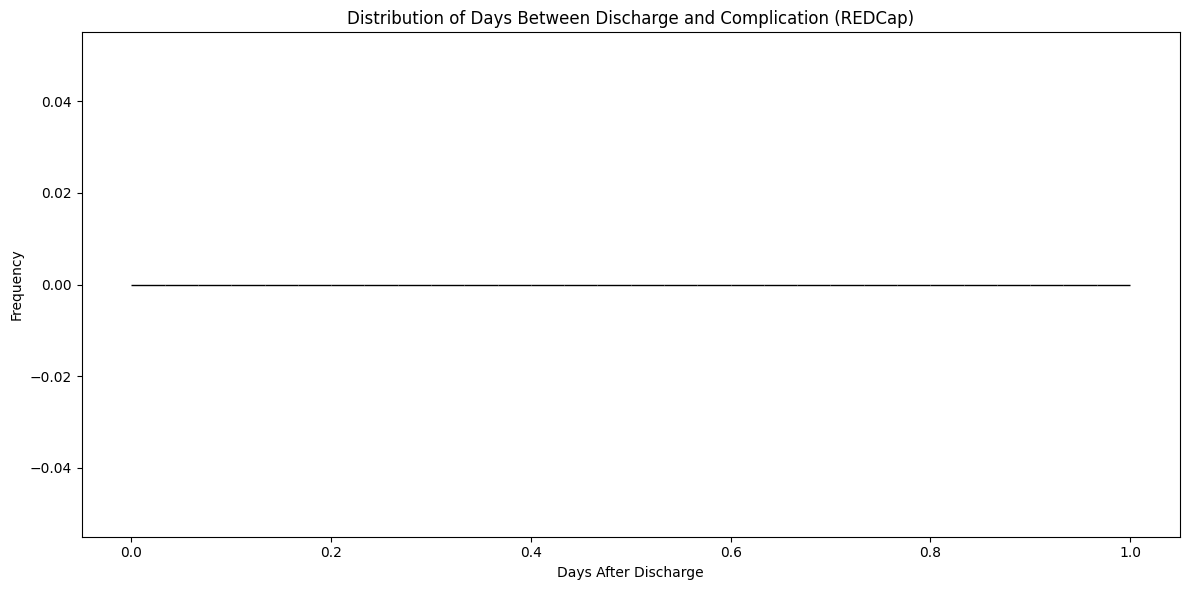

In [94]:
import matplotlib.pyplot as plt

# Calculate the difference in days and store in a temporary variable
complication_days_diff = (
    merged_final_tsqic_redcap_access["ComplicationDate_redcap"] - 
    merged_final_tsqic_redcap_access["DischargeDate_redcap"]
).dt.days

# Filter for positive differences (complications after discharge)
positive_differences = complication_days_diff[complication_days_diff > 0]

# Plot the differences
plt.figure(figsize=(12, 6))
plt.hist(positive_differences, bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Days Between Discharge and Complication (REDCap)")
plt.xlabel("Days After Discharge")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

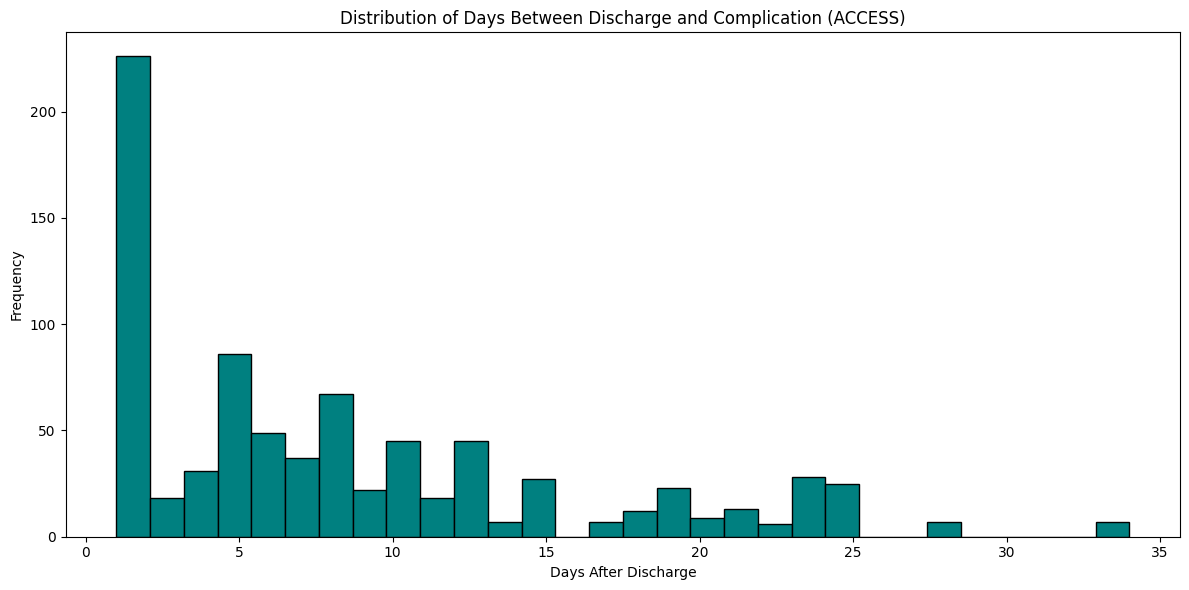

In [95]:
import matplotlib.pyplot as plt

# Calculate the difference in days and store in a temporary variable
complication_days_diff = (
    merged_final_tsqic_redcap_access["ComplicationDate_access"] - 
    merged_final_tsqic_redcap_access["DischargeDate_access"]
).dt.days

# Filter for positive differences (complications after discharge)
positive_differences = complication_days_diff[complication_days_diff > 0]

# Plot the differences
plt.figure(figsize=(12, 6))
plt.hist(positive_differences, bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Days Between Discharge and Complication (ACCESS)")
plt.xlabel("Days After Discharge")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

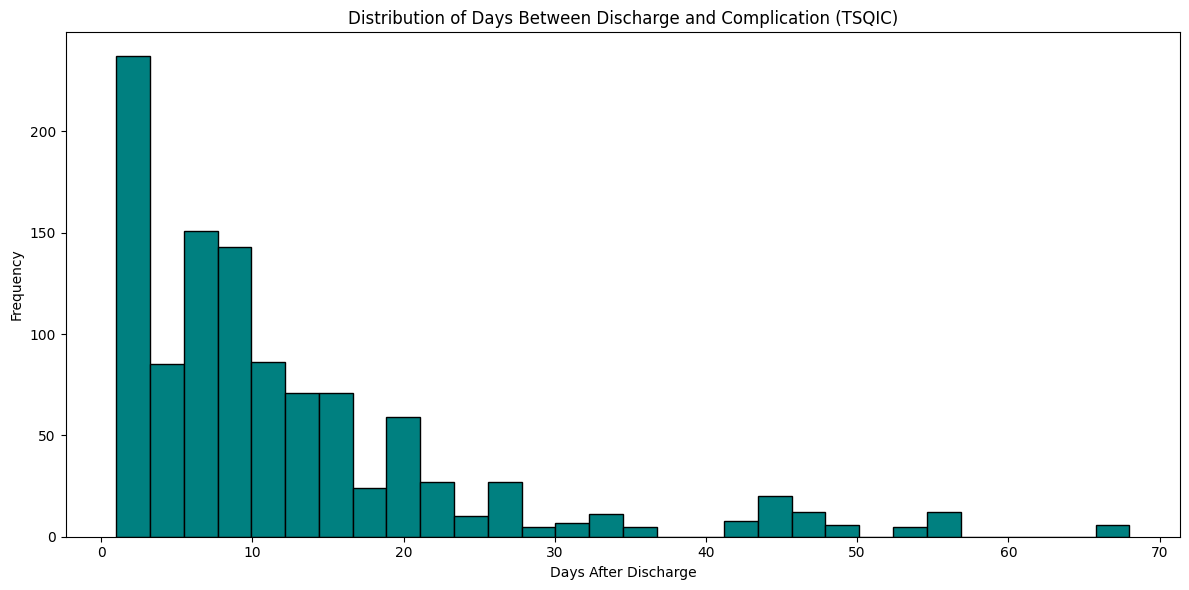

In [96]:
import matplotlib.pyplot as plt

# Calculate the difference in days and store in a temporary variable
complication_days_diff = (
    merged_final_tsqic_redcap_access["ComplicationDate_tsqic"] - 
    merged_final_tsqic_redcap_access["DischargeDate_tsqic"]
).dt.days

# Filter for positive differences (complications after discharge)
positive_differences = complication_days_diff[complication_days_diff > 0]

# Plot the differences
plt.figure(figsize=(12, 6))
plt.hist(positive_differences, bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Days Between Discharge and Complication (TSQIC)")
plt.xlabel("Days After Discharge")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### check LOS > 60

In [102]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [98]:
merged_final_tsqic_redcap_access['los'].describe()

count    1382.000000
mean       48.692475
std        49.284822
min         2.000000
25%         7.000000
50%        21.000000
75%       106.000000
max       371.000000
Name: los, dtype: float64

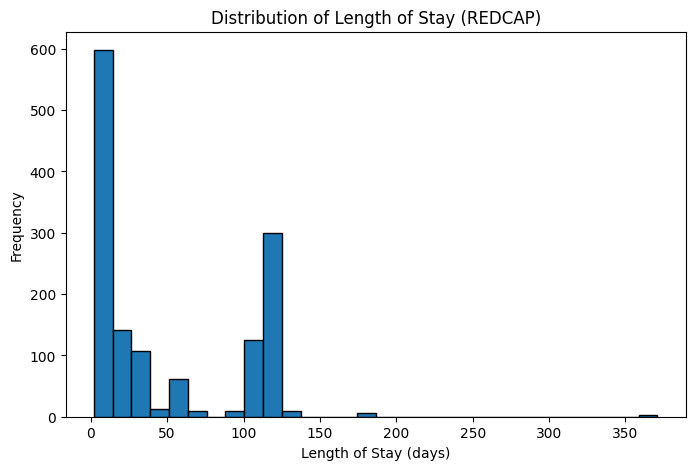

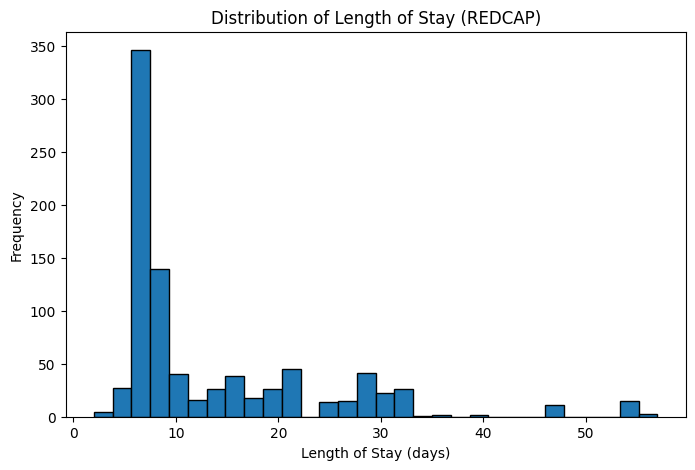

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [103]:
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['los'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (REDCAP)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

# Filter out rows where 'los' is less than 60, ignoring NaN values
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access['los'].isna()) | 
    (merged_final_tsqic_redcap_access['los'] <= 60)
]

# Check the updated dimensions
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['los'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (REDCAP) - after')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

merged_final_tsqic_redcap_access

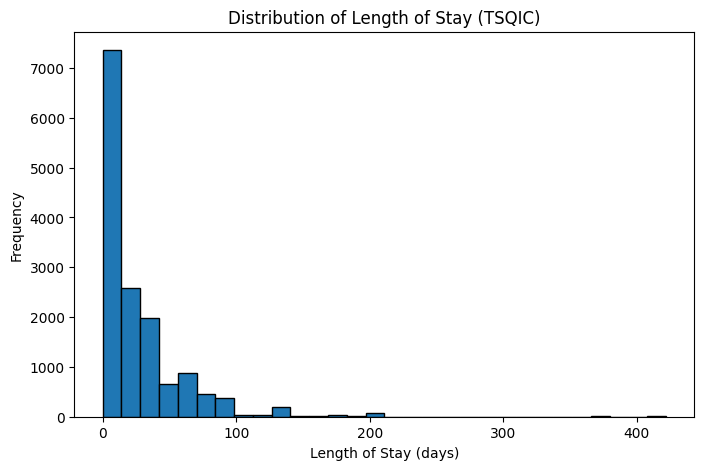

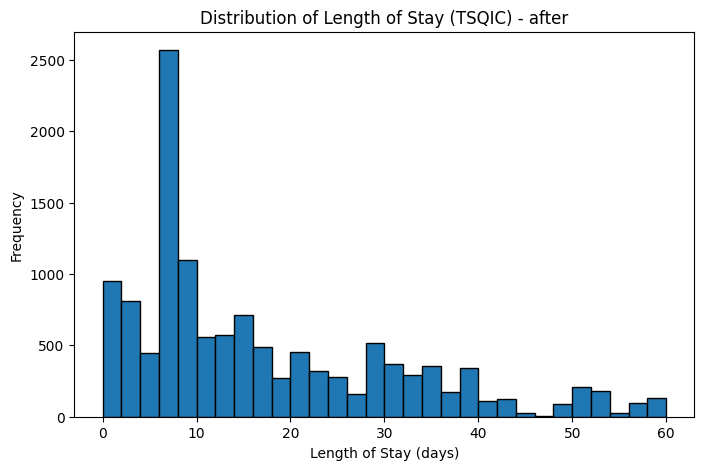

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [113]:
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['estimated_los_tsqic'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (TSQIC)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

# Filter out rows where 'los' is less than 60, ignoring NaN values
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access['estimated_los_tsqic'].isna()) | 
    (merged_final_tsqic_redcap_access['estimated_los_tsqic'] <= 60)
]

# Check the updated dimensions
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['estimated_los_tsqic'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (TSQIC) - after')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

merged_final_tsqic_redcap_access


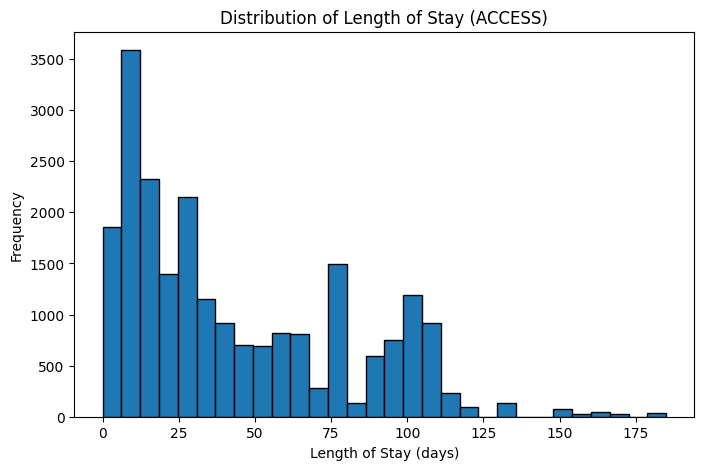

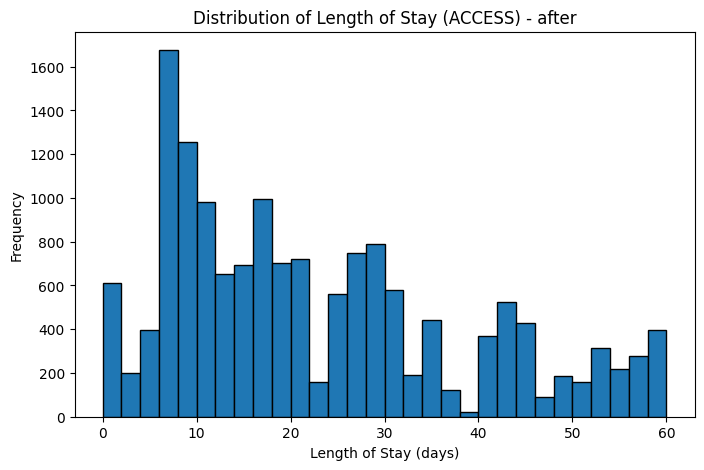

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [114]:
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['estimated_los_access'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (ACCESS)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()


# Filter out rows where 'los' is less than 60, ignoring NaN values
merged_final_tsqic_redcap_access = merged_final_tsqic_redcap_access[
    (merged_final_tsqic_redcap_access['estimated_los_access'].isna()) | 
    (merged_final_tsqic_redcap_access['estimated_los_access'] <= 60)
]

# Check the updated dimensions
plt.figure(figsize=(8, 5))
plt.hist(merged_final_tsqic_redcap_access['estimated_los_access'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Length of Stay (ACCESS) - after')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

merged_final_tsqic_redcap_access

### Print data

In [115]:
merged_final_tsqic_redcap_access

,id,operation_date_tsqic,ComplicationDate_tsqic,System_tsqic,Complication_tsqic,Grade,GradeLetter,readmission_30d_tsqic,Prolonged,Comments,...,Case Number,ComplicationDate_access,Complication_access,Clavien score,operation_date_access,admission_date_access,DischargeDate_access,_merge_access,estimated_los_access,_merge_tsqic_redcap_access
0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80713729.0,NaT,NaN,NaN,2009-05-27,2009-05-27,2009-05-27,both,0.0,all
1,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98762860.0,NaT,NaN,NaN,NaT,2012-04-21,2012-04-27,thirdtab_only,NaN,all
2,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98795837.0,NaT,NaN,NaN,2011-08-26,2011-08-26,2011-08-26,both,0.0,all
3,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98868053.0,NaT,NaN,NaN,2010-02-20,2010-02-08,2010-03-08,both,16.0,all
4,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98914582.0,NaT,NaN,NaN,2009-02-25,2009-02-25,2009-03-05,both,8.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,1756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49124,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49125,1757,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only
49126,1758,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,tsqic_redcap_only


In [116]:
# Save to a new Excel file
merged_final_tsqic_redcap_access.to_excel("Merged_TSQIC_REDCap_ACCESS.xlsx", index=False)